In [51]:
from __future__ import division
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
from pyomo.opt import SolverFactory
from pyomo.core import Var
import pyomo.environ as en
import seaborn as sns

import time

%matplotlib inline

In [52]:
# set up seaborn the way you like
sns.set_style({'axes.linewidth': 1, 'axes.edgecolor':'black', 'xtick.direction': \
               'out', 'xtick.major.size': 4.0, 'ytick.direction': 'out', 'ytick.major.size': 4.0, \
              'axes.facecolor': 'white','grid.color': '.8', 'grid.linestyle': u'-', 'grid.linewidth': 0.5})

该数据表包含了15个社区的电池配置，index_col避免了从0开始的序号

In [53]:
from battery import Battery
metadata = pd.read_csv('./peking_unit/peking_site_battery.csv', index_col= 0)
metadata.head()

,Battery_Capacity,Battery_Power,Battery_Charge_Efficiency,Battery_Discharge_Efficiency
SiteId,,,,
4271,399.36,399.36,0.953,0.953
13775,204.80,204.80,0.953,0.953
13567,184.32,184.32,0.953,0.953
16018,634.88,634.88,0.953,0.953
19644,450.56,450.56,0.953,0.953


site_id = 11383 表示计算11383社区

In [54]:
site_id = 4271

parameters = metadata.loc[metadata.index == site_id]

In [55]:
batt = Battery(capacity=parameters["Battery_Capacity"],
           charging_power_limit=parameters["Battery_Power"],
           discharging_power_limit=-parameters["Battery_Power"],
           charging_efficiency=parameters["Battery_Charge_Efficiency"],
           discharging_efficiency=parameters["Battery_Discharge_Efficiency"])

In [56]:
# read the testdata
testData = pd.read_csv('./peking_unit/'+str(site_id)+'.csv')

In [57]:
# have a quick look at the testdata
testData.head()

,consumption,pv,price_buy,price_sell
0,2032.176365,0.0,0.117,0.3598
1,2015.733524,0.0,0.117,0.3598
2,1778.428062,0.0,0.117,0.3598
3,2076.597933,0.0,0.117,0.3598
4,2188.203212,0.0,0.117,0.3598


Now, let's use the data provided to work out the maximum possible saving provided by the battery <br>
We will use data from the actual_consumption, actual_pv, price_sell_00 and price_buy_00 columns <br>

In [58]:
# here convert the various timeseries to numpy arrays
# replace these with the arrays from the site you want to model
load = testData['consumption'].values
PV = testData['pv'].values
sellPrice = testData['price_sell'].values
buyPrice = testData['price_buy'].values

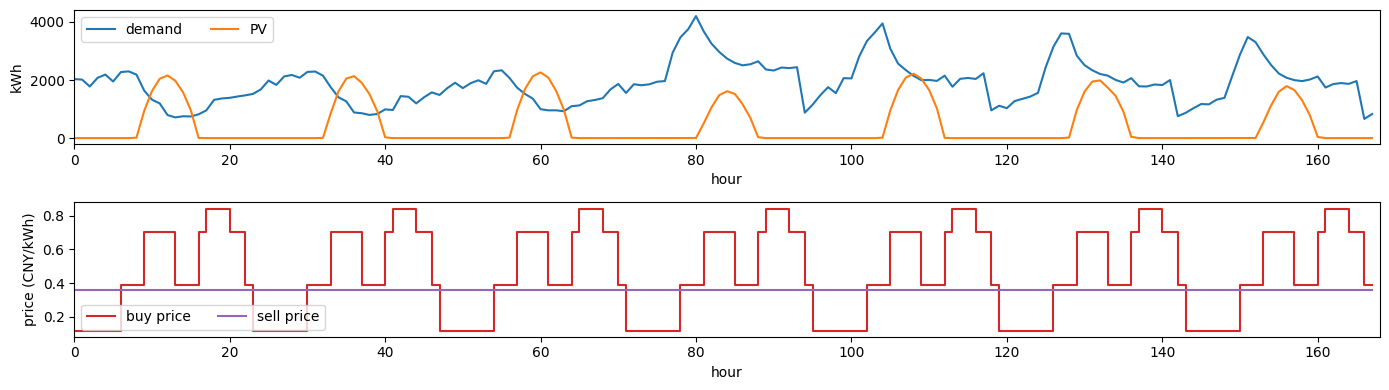

In [59]:
colors = sns.color_palette()
hrs = np.arange(0, len(load))
fig = plt.figure(figsize=(14, 4))

# First subplot
ax1 = fig.add_subplot(2, 1, 1)
l1, = ax1.plot(hrs[:168], load[:168], color=colors[0])
l2, = ax1.plot(hrs[:168], PV[:168], color=colors[1])
ax1.set_xlabel('hour'), ax1.set_ylabel('kWh')
ax1.legend([l1, l2], ['demand', 'PV'], ncol=2)
ax1.set_xlim([0, 168])

# Second subplot
ax2 = fig.add_subplot(2, 1, 2)
ax2.step(hrs[:168], buyPrice[:168], color=colors[3], label='buy price')
ax2.step(hrs[:168], sellPrice[:168], color=colors[4], label='sell price')
ax2.set_xlabel('hour'), ax2.set_ylabel('price (CNY/kWh)')
ax2.legend(ncol=2)
ax2.set_xlim([0, 168])

fig.tight_layout()
plt.show()


### We are now ready to schedule the battery using pyomo!

First of all, pyomo uses indexed variables, therefore we create these using dictionaries

In [60]:
priceDict1 = dict(enumerate(sellPrice))
priceDict2 = dict(enumerate(buyPrice))

The net is the consumers load+PV <br>
The way that the price is formulated is that if the net is greater than 0, then the consumer is buying from the grid and electricity costs the buy_price <br>
If the net is less than 0, then the consumer is selling electricity to the grid and the electricity is sold at price_sell <br>
Therefore, we split the net into positive (buying) and negative (selling) load

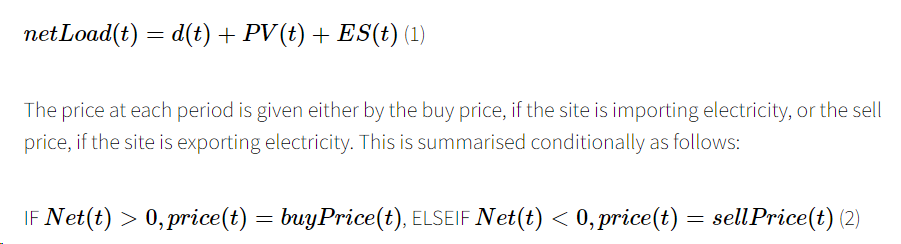

In [61]:
net = load-PV
# split load into +ve and -ve
posLoad = np.copy(load-PV)
negLoad = np.copy(load-PV)
for j,e in enumerate(net):
    if e>=0:
        negLoad[j]=0
    else:
        posLoad[j]=0
posLoadDict = dict(enumerate(posLoad))
negLoadDict = dict(enumerate(negLoad))

In [62]:
# now set up the pyomo model
m = en.ConcreteModel()

# we use rangeset to make a sequence of integers
# time is what we will use as the model index
m.Time = en.RangeSet(0, len(net)-1)

#### Variables
Now we define the variables that we are interested in: <br>
We formulate the problem such that our decision variables are *posNetLoad* and *negNetLoad* <br>
See the objective fn.

In [63]:
# variables (all indexed by Time)

m.SOC = en.Var(m.Time, bounds=(0, batt.capacity.iloc[0]), initialize=0) # 0
m.posDeltaSOC = en.Var(m.Time, initialize=0) #1
m.negDeltaSOC = en.Var(m.Time, initialize=0) #2
m.posEInGrid = en.Var(m.Time, bounds=(0,batt.charging_power_limit.iloc[0]), initialize=0) #3
m.posEInPV = en.Var(m.Time, bounds=(0,batt.charging_power_limit.iloc[0]), initialize=0) #4
m.negEOutLocal = en.Var(m.Time, bounds=(batt.discharging_power_limit.iloc[0],0), initialize=0) #5
m.negEOutExport = en.Var(m.Time, bounds=(batt.discharging_power_limit.iloc[0],0), initialize=0) #6
m.posNetLoad = en.Var(m.Time, initialize=posLoadDict) #7
m.negNetLoad = en.Var(m.Time, initialize=negLoadDict) #8

The numbers commented after are the indices that we will use when looping through the model components afterwards to get the final values of the variables after the optimisation has been completed

The Boolean variables are what we will use to denote whether the battery is charging or discharging at a particular period

In [64]:
# Boolean variables (again indexed by Time) 用布尔值判断电池充放电
m.Bool_char=en.Var(m.Time,within=en.Boolean) #9
m.Bool_dis=en.Var(m.Time,within=en.Boolean,initialize=0) #10

In [65]:
# parameters (indexed by time) 价格和荷载
m.priceSell = en.Param(m.Time, initialize=priceDict1)
m.priceBuy = en.Param(m.Time, initialize=priceDict2)
m.posLoad = en.Param(m.Time, initialize=posLoadDict)
m.negLoad = en.Param(m.Time, initialize=negLoadDict)

In [66]:
# single value parameters 
m.etaChg = en.Param(initialize = batt.charging_efficiency.iloc[0])
m.etaDisChg = en.Param(initialize = batt.discharging_efficiency.iloc[0])
m.ChargingLimit = en.Param(initialize = batt.charging_power_limit.iloc[0])
m.DischargingLimit = en.Param(initialize = batt.discharging_power_limit.iloc[0])

#### Objective function 
Now define the objective function that we are going to minimise (the cost of the site's electricity)

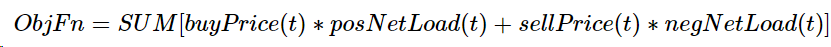

In [67]:
# objective function
def Obj_fn(m):
    return sum((m.priceBuy[i]*m.posNetLoad[i]) + (m.priceSell[i]*(m.negLoad[i]+m.posEInPV[i])) for i in m.Time)
m.total_cost = en.Objective(rule=Obj_fn,sense=en.minimize)

In the above posNetLoad and negNetLoad are variables, indexed by time that will change dependent on the action of the battery <br>
They have initially been assigned using posLoad and negLoad, which correspond to no battery action

We now need to think about the constraints on the model. First of all, we add a constraint which represents the finite physical capacity of the battery, which cannot be above the maximum and cannot fall below zero

In [68]:
# constraints
# first we define the constraint at each time period
def SOC_rule(m,t):
    if t==0:
        return (m.SOC[t] == m.posDeltaSOC[t]+m.negDeltaSOC[t])
    else:
        return (m.SOC[t] == m.SOC[t-1]+m.posDeltaSOC[t]+m.negDeltaSOC[t])   
# then we specify that this constraint is indexed by time
m.Batt_SOC = en.Constraint(m.Time,rule=SOC_rule)

#### boolean constraints - the integers
The next set of constraints is the "Integer" part in the Mixed Integer Linear Program formulation. <br>
These constraints explicitly constrain that the battery can only charge OR discharge during one time period <br>
The observant might notice that in this specific example, these constraints aren't actually required, since in our objective function there will never be an economic benefit to this type of action <br>
However, it is good to see how they are set up, they can make the optimisation faster and many cases they are required

In [69]:
# we use bigM to bound the problem
# boolean constraints
bigM=1000000

def Bool_char_rule_1(m,i):
    return((m.posDeltaSOC[i])>=-bigM*(m.Bool_char[i]))
# if battery is charging, charging must be greater than -large
# if not, charging geq zero
def Bool_char_rule_2(m,i):
    return((m.posDeltaSOC[i])<=bigM*(1-m.Bool_dis[i]))
# if batt discharging, charging must be leq zero
# if not, charging leq +large
def Bool_char_rule_3(m,i):
    return((m.negDeltaSOC[i])<=bigM*(1-m.Bool_char[i]))
# if batt discharge, discharge leq POSITIVE large
# if not, discharge leq 0
def Bool_char_rule_4(m,i):
    return((m.negDeltaSOC[i])>=-bigM*(m.Bool_dis[i]))
# if batt charge, discharge geq zero
# if not, discharge geq -large
def Batt_char_dis(m,i):
    return (m.Bool_char[i]+m.Bool_dis[i],1)

m.Batt_ch1=en.Constraint(m.Time,rule=Bool_char_rule_1)
m.Batt_ch2=en.Constraint(m.Time,rule=Bool_char_rule_2)
m.Batt_cd3=en.Constraint(m.Time,rule=Bool_char_rule_3)
m.Batt_cd4=en.Constraint(m.Time,rule=Bool_char_rule_4)
m.Batt_char_dis=en.Constraint(m.Time,rule=Batt_char_dis)

#### battery efficiency
The next constraints deal with the battery efficiency: <br>
We ensure that any change in the battery in the battery's state of charge at a particular period due to charging is reduced by the charging efficieny <br>
Similarly, we ensure that the energy output from the battery is reduced when it is converted to an output

In [70]:
#ensure charging efficiency is divided
def pos_E_in_rule(m,i):
    return (m.posEInGrid[i]+m.posEInPV[i]) == m.posDeltaSOC[i]/m.etaChg
m.posEIn_cons = en.Constraint(m.Time, rule=pos_E_in_rule)
# ensure discharging eff multiplied
def neg_E_out_rule(m,i):
    return (m.negEOutLocal[i]+m.negEOutExport[i]) == m.negDeltaSOC[i]*m.etaDisChg
m.negEOut_cons = en.Constraint(m.Time, rule=neg_E_out_rule)

#### Charging and discharging power limits
Now ensure that the charging and discharging power limits of the battery are respected. <br>
Note that we have opted to split the energy into that coming-from the grid (posEInGrid), going-to the grid (negEOutExport), coming from local PV (posEInPV) and being used locally (negEOutLocal)

In [71]:
# ensure charging rate obeyed
def E_charging_rate_rule(m,i):
    return (m.posEInGrid[i]+m.posEInPV[i])<=m.ChargingLimit
m.chargingLimit_cons = en.Constraint(m.Time, rule=E_charging_rate_rule)
# ensure DIScharging rate obeyed
def E_discharging_rate_rule(m,i):
    return (m.negEOutLocal[i]+m.negEOutExport[i])>=m.DischargingLimit
m.dischargingLimit_cons = en.Constraint(m.Time, rule=E_discharging_rate_rule)

#### Further constraints to ensure physical sense

In [72]:
# ensure that posEInPV cannot exceed local PV
def E_solar_charging_rule(m,i):
    return m.posEInPV[i]<=-m.negLoad[i]
m.solarChargingLimit_cons = en.Constraint(m.Time, rule=E_solar_charging_rule)
# ensure that negEOutLocal cannot exceed local demand
def E_local_discharge_rule(m,i):
    return m.negEOutLocal[i]>=-m.posLoad[i]
m.localDischargingLimit_cons = en.Constraint(m.Time, rule=E_local_discharge_rule)

#### Rules for actually calculating the main decision variables

In [73]:
# calculate the net positive demand
def E_pos_net_rule(m,i):
    return m.posNetLoad[i] == m.posLoad[i]+m.posEInGrid[i]+m.negEOutLocal[i]
m.E_posNet_cons = en.Constraint(m.Time,rule=E_pos_net_rule)

# calculate export
def E_neg_net_rule(m,i):
    return m.negNetLoad[i] == m.negLoad[i]+m.posEInPV[i]+m.negEOutExport[i]
m.E_negNet_cons = en.Constraint(m.Time,rule=E_neg_net_rule)

#### Running pyomo
Now we just need to get pyomo to run, so first we need to specify the path to the solver:

In [74]:
# set the path to the solver
# SPECIFY YOUR OWN PATH TO CPLEX OR WHATEVER OTHER SOLVER
opt = SolverFactory("cplex")

#### Now we can run 

In [75]:
# 计算所用时间
t = time.time()
results = opt.solve(m)
elapsed = time.time() - t
print('Time elapsed:', elapsed)

Time elapsed: 3.4956600666046143


#### Reading the outputs
I prefer having my outputs as numpy arrays, as I am more used to them <br>
Remember the order in which we defined the variables? Well that's the way that pyomo spits them out. Hence we numbered the variables as we declared them <br>
I find it easiest to just loop through the variables and store the ones that we are interested in

In [76]:
j = 0
for v in m.component_objects(Var, active=True):
    print (j, v.getname())
    j+=1

0 SOC
1 posDeltaSOC
2 negDeltaSOC
3 posEInGrid
4 posEInPV
5 negEOutLocal
6 negEOutExport
7 posNetLoad
8 negNetLoad
9 Bool_char
10 Bool_dis


In [77]:
# now let's read in the value for each of the variables 
outputVars = np.zeros((9,len(sellPrice)))

In [78]:
j = 0
for v in m.component_objects(Var, active=True):
    print (v.getname())
    #print varobject.get_values()
    varobject = getattr(m, str(v))
    for index in varobject:
        outputVars[j,index] = varobject[index].value
    j+=1
    if j>=9:
        break

SOC
posDeltaSOC
negDeltaSOC
posEInGrid
posEInPV
negEOutLocal
negEOutExport
posNetLoad
negNetLoad


The above cell is the solution, but we can also calculate how much better this new solution is than the no battery case (or any other battery action that you may consider)

In [79]:
df = pd.read_csv('./peking_unit/' + str(site_id) + '.csv')

# 追加数据列
df['posEInPV'] = outputVars[4]

# 保存修改后的CSV文件
df.to_csv('./peking_unit/' + str(site_id) + '_posEInPV.csv', index=False)

# plt.plot(outputVars[4])

In [88]:
# get the total cost
cost_without_system = np.sum([(buyPrice[i]*load[i]) for i in range(len(buyPrice))])

cost_without_batt = np.sum([(buyPrice[i]*posLoad[i] + sellPrice[i]*negLoad[i]) for i in range(len(buyPrice))])

cost_with_batt = np.sum([(buyPrice[i]*outputVars[7,i] + sellPrice[i]*outputVars[8,i]) for i in range(len(buyPrice))])

print('Cost without system:',int(cost_without_system))
print ('Cost without battery:', int(cost_without_batt))
print ('Cost with battery:', int(cost_with_batt),'\n')
print ('cost_save:',cost_without_batt - cost_with_batt )
print ('Score_battery: %.4f'%((cost_with_batt - cost_without_batt) / np.abs(cost_without_batt)))

benifit = cost_without_system - cost_with_batt
%store benifit
benifit

Cost without system: 7089631
Cost without battery: 3528507
Cost with battery: 3420278 

cost_save: 108229.1994725815
Score_battery: -0.0307
Stored 'benifit' (float64)


3669352.6373068322

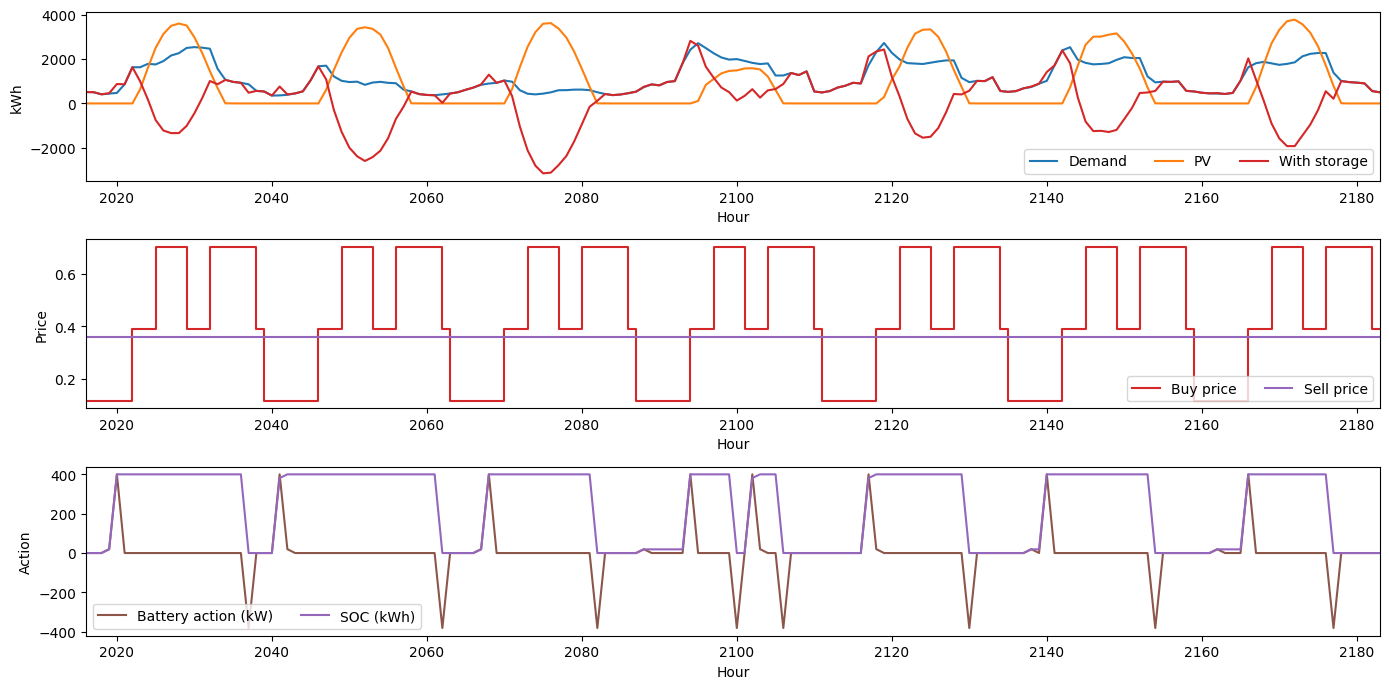

In [81]:
newNetLoad = outputVars[7]+outputVars[8]
# 新的时间段
hours_per_week = 24 * 7
spring_hours = list(range(hours_per_week * 12, hours_per_week * 13))

fig = plt.figure(figsize=(14, 7))

# 第一个子图：电力需求、光伏发电量和带储能的净负荷
ax1 = fig.add_subplot(3, 1, 1)
l1, = ax1.plot(spring_hours, load[spring_hours], color=colors[0])
l2, = ax1.plot(spring_hours, PV[spring_hours], color=colors[1])
l3, = ax1.plot(spring_hours, newNetLoad[spring_hours], color=colors[3])
ax1.set_xlabel('Hour')
ax1.set_ylabel('kWh')
ax1.legend([l1, l2, l3], ['Demand', 'PV', 'With storage'], ncol=3)
ax1.set_xlim([spring_hours[0], spring_hours[-1]]) 

# 第二个子图：购买价格和出售价格（阶梯曲线）
ax2 = fig.add_subplot(3, 1, 2)
ax2.step(spring_hours, buyPrice[spring_hours], color=colors[3], label='Buy price')
ax2.step(spring_hours, sellPrice[spring_hours], color=colors[4], label='Sell price')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Price')
ax2.legend(ncol=2)
ax2.set_xlim([spring_hours[0], spring_hours[-1]]) 

# 第三个子图：电池动作和SOC
ax3 = fig.add_subplot(3, 1, 3)
l1, = ax3.plot(spring_hours, np.sum(outputVars[3:7, spring_hours], axis=0), color=colors[5])
l2, = ax3.plot(spring_hours, outputVars[0][spring_hours], color=colors[4])
ax3.set_xlabel('Hour')
ax3.set_ylabel('Action')
ax3.legend([l1, l2], ['Battery action (kW)', 'SOC (kWh)'], ncol=2)
ax3.set_xlim([spring_hours[0], spring_hours[-1]]) 

fig.tight_layout()
plt.show()